## Pointcloud contrastive learning



## Setup

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
import torch
version = f"https://data.pyg.org/whl/torch-{torch.__version__}.html"
try: 
    import torch_geometric
except:
    !echo $version
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f $version
    import torch_geometric

## Dataset




In [ ]:
from torch_geometric.datasets import ShapeNet

dataset = ShapeNet(root=".", categories=["Car", "Table"]).shuffle()[:3000]
print("Number of Samples: ", len(dataset))
print("Sample: ", dataset[0])

Extracting ./shapenetcore_partanno_segmentation_benchmark_v0_normal.zip
Processing...


Number of Samples:  3000
Sample:  Data(x=[2582, 3], y=[2582], pos=[2582, 3], category=[1])


Done!


Attribute Name  | Description
-------------------|------------------
Pos       | Normalized positions as 3D coordinates
X       |  Normal vectors 
Y       | Class label 

In [ ]:
import plotly.express as px

def plot_3d_shape(shape):
    print("Number of data points: ", shape.x.shape[0])
    print("Shape category:", shape.category.item())
    x = shape.pos[:, 0]
    y = shape.pos[:, 1]
    z = shape.pos[:, 2]
    fig = px.scatter_3d(x=x, y=y, z=z, opacity=0.3)
    fig.show()

# Pick a sample
sample_idx = 2800
plot_3d_shape(dataset[sample_idx])

Number of data points:  2698
Shape category: 1


In [ ]:
cat_dict = {key: 0 for key in dataset.categories}
for datapoint in dataset: cat_dict[dataset.categories[datapoint.category.int()]]+=1
cat_dict

{'Car': 444, 'Table': 2556}

## Data Preparation






In [ ]:
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as transforms

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
augmentation = transforms.Compose([transforms.RandomJitter(0.05), transforms.RandomFlip(1)])

In [ ]:
sample = next(iter(data_loader))
plot_3d_shape(sample[0])

Number of data points:  2699
Shape category: 1


In [ ]:
#transformed sample
transformered = augmentation(sample)
plot_3d_shape(transformered[0])

Number of data points:  2699
Shape category: 1


## Model








In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import MLP, DynamicEdgeConv, global_max_pool


class Model(torch.nn.Module): # we use DynamicEdgeConv layers as implemented in pytorch geometric
    def __init__(self, k=20, aggr='max'):
        super().__init__()
        # Feature extraction
        self.conv1 = DynamicEdgeConv(MLP([2 * 3, 64, 64]), k, aggr)
        self.conv2 = DynamicEdgeConv(MLP([2 * 64, 128]), k, aggr)
        # Encoder head 
        self.lin1 = Linear(128 + 64, 128)
        
        self.mlp = MLP([128, 256, 32], norm=None)

    def forward(self, data, train=True):
        if train:
  
            augm_1 = augmentation(data)
            augm_2 = augmentation(data)
            
            pos_1, batch_1 = augm_1.pos, augm_1.batch
            pos_2, batch_2 = augm_2.pos, augm_2.batch

            x1 = self.conv1(pos_1, batch_1)
            x2 = self.conv2(x1, batch_1)
            h_points_1 = self.lin1(torch.cat([x1, x2], dim=1))

            x1 = self.conv1(pos_2, batch_2)
            x2 = self.conv2(x1, batch_2)
            h_points_2 = self.lin1(torch.cat([x1, x2], dim=1))
            
            h_1 = global_max_pool(h_points_1, batch_1)
            h_2 = global_max_pool(h_points_2, batch_2)
        else:
            x1 = self.conv1(data.pos, data.batch)
            x2 = self.conv2(x1, data.batch)
            h_points = self.lin1(torch.cat([x1, x2], dim=1))
            return global_max_pool(h_points, data.batch)

        # Transformation for loss function
        compact_h_1 = self.mlp(h_1)
        compact_h_2 = self.mlp(h_2)
        return h_1, h_2, compact_h_1, compact_h_2

## Training

In [ ]:
!pip install pytorch-metric-learning -q 

from pytorch_metric_learning.losses import NTXentLoss #InfoNCE loss 
loss_func = NTXentLoss(temperature=0.15)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.4/111.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.8 MB/s eta 0:00:00


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
import tqdm

def train():
    model.train()
    total_loss = 0
    for _, data in enumerate(tqdm.tqdm(data_loader)):
        data = data.to(device)
        optimizer.zero_grad()

        h_1, h_2, compact_h_1, compact_h_2 = model(data)

        embeddings = torch.cat((compact_h_1, compact_h_2))

        indices = torch.arange(0, compact_h_1.size(0), device=compact_h_2.device)
        labels = torch.cat((indices, indices))

        loss = loss_func(embeddings, labels)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    return total_loss / len(dataset)

for epoch in range(1, 30):
    loss = train()
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')
    scheduler.step()

100%|██████████| 94/94 [04:01<00:00,  2.57s/it]


Epoch 001, Loss: 1.8681


100%|██████████| 94/94 [04:00<00:00,  2.56s/it]


Epoch 002, Loss: 1.3438


100%|██████████| 94/94 [04:00<00:00,  2.56s/it]


Epoch 003, Loss: 0.9582


100%|██████████| 94/94 [04:00<00:00,  2.56s/it]


Epoch 004, Loss: 0.7388


100%|██████████| 94/94 [04:00<00:00,  2.56s/it]


Epoch 005, Loss: 0.5472


100%|██████████| 94/94 [04:00<00:00,  2.56s/it]


Epoch 006, Loss: 0.4525


100%|██████████| 94/94 [04:00<00:00,  2.56s/it]


Epoch 007, Loss: 0.4429


100%|██████████| 94/94 [04:01<00:00,  2.56s/it]


Epoch 008, Loss: 0.3790


100%|██████████| 94/94 [04:00<00:00,  2.56s/it]


Epoch 009, Loss: 0.3342


100%|██████████| 94/94 [04:00<00:00,  2.56s/it]


Epoch 010, Loss: 0.3178


100%|██████████| 94/94 [04:01<00:00,  2.57s/it]


Epoch 011, Loss: 0.2729


100%|██████████| 94/94 [04:00<00:00,  2.56s/it]


Epoch 012, Loss: 0.2647


100%|██████████| 94/94 [04:00<00:00,  2.56s/it]


Epoch 013, Loss: 0.2496


100%|██████████| 94/94 [04:00<00:00,  2.56s/it]


Epoch 014, Loss: 0.2487


100%|██████████| 94/94 [04:01<00:00,  2.57s/it]


Epoch 015, Loss: 0.2558


100%|██████████| 94/94 [04:00<00:00,  2.56s/it]


Epoch 016, Loss: 0.2386


100%|██████████| 94/94 [04:01<00:00,  2.57s/it]


Epoch 017, Loss: 0.2336


100%|██████████| 94/94 [04:00<00:00,  2.56s/it]


Epoch 018, Loss: 0.2262


100%|██████████| 94/94 [04:00<00:00,  2.56s/it]


Epoch 019, Loss: 0.2319


100%|██████████| 94/94 [04:01<00:00,  2.56s/it]


Epoch 020, Loss: 0.2147


100%|██████████| 94/94 [04:00<00:00,  2.56s/it]


Epoch 021, Loss: 0.1946


100%|██████████| 94/94 [04:01<00:00,  2.56s/it]


Epoch 022, Loss: 0.1856


100%|██████████| 94/94 [04:00<00:00,  2.56s/it]


Epoch 023, Loss: 0.1877


100%|██████████| 94/94 [04:00<00:00,  2.56s/it]


Epoch 024, Loss: 0.1843


100%|██████████| 94/94 [04:01<00:00,  2.56s/it]


Epoch 025, Loss: 0.1829


100%|██████████| 94/94 [04:01<00:00,  2.57s/it]


Epoch 026, Loss: 0.1864


100%|██████████| 94/94 [04:01<00:00,  2.56s/it]


Epoch 027, Loss: 0.1861


100%|██████████| 94/94 [04:01<00:00,  2.56s/it]


Epoch 028, Loss: 0.1784


100%|██████████| 94/94 [04:00<00:00,  2.56s/it]

Epoch 029, Loss: 0.1806


## Evaluation

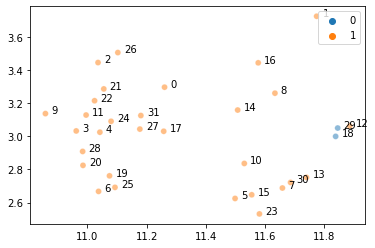

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sample = next(iter(data_loader))

h = model(sample.to(device), train=False)
h = h.cpu().detach()
labels = sample.category.cpu().detach().numpy()

# t-SNE Embeddings
h_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(h.numpy())

ax = sns.scatterplot(x=h_embedded[:,0], y=h_embedded[:,1], hue=labels, 
                    alpha=0.5, palette="tab10")

annotations = list(range(len(h_embedded[:,0])))

def label_points(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(int(point['val'])))

label_points(pd.Series(h_embedded[:,0]), 
            pd.Series(h_embedded[:,1]), 
            pd.Series(annotations), 
            plt.gca()) 